In [2]:
%pylab inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5,6'

import sys
sys.path.append('../')

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.lax as lax
from jax.experimental.maps import xmap
from jax.experimental.ode import odeint
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
from jax.experimental.pjit import pjit
from jaxpm.pm import cic_paint, cic_read, fftk
from functools import partial
import jax_cosmo as jc

from jaxpm.growth import growth_factor, growth_rate, dGfa

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_3163799/1536366819.py:12: DeprecationWarning: jax.experimental.maps and jax.experimental.maps.xmap are deprecated and will be removed in a future release. Use jax.experimental.shard_map or jax.vmap with the spmd_axis_name argument for expressing SPMD device-parallel computations. Please file an issue on https://github.com/google/jax/issues if neither jax.experimental.shard_map nor jax.vmap are suitable for your use case.
  from jax.experimental.maps import xmap


In [3]:
nc=512
boxsize=1024. # Mpx/h
halo_size=16

In [4]:
def cic_paint(mesh, positions):
  """ Paints positions onto mesh
  mesh: [nx, ny, nz]
  positions: [npart, 3]
  """
  positions = jnp.expand_dims(positions, 1)
  floor = jnp.floor(positions)
  connection = jnp.array([[[0, 0, 0], [1., 0, 0], [0., 1, 0], 
                           [0., 0, 1], [1., 1, 0], [1., 0, 1], 
                           [0., 1, 1], [1., 1, 1]]])

  neighboor_coords = floor + connection
  kernel = 1. - jnp.abs(positions - neighboor_coords)
  kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]  

  neighboor_coords = jnp.mod(neighboor_coords.reshape([-1,8,3]).astype('int32'), mesh.shape[-1])

  dnums = jax.lax.ScatterDimensionNumbers(
    update_window_dims=(),
    inserted_window_dims=(0, 1, 2),
    scatter_dims_to_operand_dims=(0, 1, 2))
  mesh = lax.scatter_add(mesh, 
                         neighboor_coords, 
                         kernel.reshape([-1,8]),
                         dnums)
  return mesh

def cic_read(mesh, positions):
  """ Paints positions onto mesh
  mesh: [nx, ny, nz]
  positions: [npart, 3]
  """  
  positions = jnp.expand_dims(positions, 1)
  floor = jnp.floor(positions)
  connection = jnp.array([[[0, 0, 0], [1., 0, 0], [0., 1, 0], 
                           [0., 0, 1], [1., 1, 0], [1., 0, 1], 
                           [0., 1, 1], [1., 1, 1]]])

  neighboor_coords = floor + connection
  kernel = 1. - jnp.abs(positions - neighboor_coords)
  kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]  

  #neighboor_coords = neighboor_coords.reshape([-1,8,3]).astype('int32')

  neighboor_coords = jnp.mod(neighboor_coords.astype('int32'), mesh.shape[-1])

  return (mesh[neighboor_coords[...,0], 
               neighboor_coords[...,1], 
               neighboor_coords[...,3]]*kernel).sum(axis=-1)


In [5]:
# Defining the main operations
@partial(xmap,
         in_axes={0:'x', 1:'y'},
         out_axes=['x','y',...],
         axis_sizes={'x':nc, 'y':nc},
         axis_resources={'x': 'nx', 'y':'ny',})
                         #'key_x':'nx', 'key_y':'ny'})
def pnormal(key):
    return jax.random.normal(key, shape=[nc])

@partial(xmap,
         in_axes={0:'x', 1:'y'},
         out_axes=['x','y',...],
         axis_resources={'x': 'nx', 'y': 'ny'})
def pfft3d(mesh):
    # [x, y, z]
    mesh = jnp.fft.fft(mesh)
    mesh = lax.all_to_all(mesh, 'x', 0, 0) # [z, y, x]
    mesh = jnp.fft.fft(mesh)
    mesh = lax.all_to_all(mesh, 'y', 0, 0) # [z, x, y]
    return jnp.fft.fft(mesh)

@partial(xmap,
         in_axes={0:'x', 1:'y'},
         out_axes=['x','y',...],
         axis_resources={'x': 'nx', 'y': 'ny'})
def pifft3d(mesh):
    mesh = jnp.fft.ifft(mesh) 
    mesh = lax.all_to_all(mesh, 'y', 0, 0)
    mesh = jnp.fft.ifft(mesh)
    mesh = lax.all_to_all(mesh, 'x', 0, 0) 
    return jnp.fft.ifft(mesh).real

In [6]:
@partial(xmap,
         in_axes=(['x','y',...],
                  ['x'],
                  ['y'],
                  [...],[...],[...]),
         out_axes=['x','y',...],
         axis_resources={'x': 'nx', 'y': 'ny'})
def cwise_fn(kfield, kx, ky, kz, k, pk):
    kk = jnp.sqrt((kx / boxsize * nc)**2 + (ky / boxsize * nc)**2 +
                 (kz / boxsize * nc)**2)
    pkmesh = jc.scipy.interpolate.interp(kk, k, pk)
    return kfield*(pkmesh*nc**3/boxsize**3)**0.5

def get_initial_cond(cosmo, seed):
    # Get real density field
    linear = pnormal(jax.random.split(seed, nc*nc).reshape(nc,nc,-1))
    lineark = pfft3d(linear)
    
    k = jnp.logspace(-4, 2, 256)
    pk = jc.power.linear_matter_power(cosmo, k)
    kvec = fftk([nc,nc,nc], symmetric=False)
    
    lineark = cwise_fn(lineark, kvec[0].squeeze(),kvec[1].squeeze(),kvec[2].squeeze(), k, pk)
    
    return pifft3d(lineark)

In [7]:
key = jax.random.PRNGKey(42)
# keys = jax.random.split(key, 4).reshape([2,2,2])

# We reshape all our devices to the mesh shape we want
devices = np.array(jax.local_devices()).reshape((2, 2))

cosmo = jc.Planck15()

Ok, cool, now let's implement LPT

In [8]:
@partial(xmap,
         in_axes=([...]),
         out_axes={0:'sx', 2:'sy'},
         axis_sizes={'sx':2, 'sy':2},
         axis_resources={'sx': 'nx', 'sy': 'ny'})
def pmeshgrid(x, y, z):
    return jnp.stack(jnp.meshgrid(x,y,z),axis=-1)

@partial(xmap,
         in_axes=(['x','y','z'],
                  ['x'], ['y'], ['z']),
         out_axes=(['x','y','z'],
                   ['x','y','z'],
                   ['x','y','z']),
         axis_resources={'x': 'nx', 'y': 'ny'})
def papply_gradient_laplace(kfield, kx, ky, kz):
    kk = (kx**2 + ky**2 + kz**2)
    kernel = jnp.where(kk == 0, 1., 1./kk)
    return (kfield * kernel * 1j * 1 / 6.0 * (8 * jnp.sin(ky) - jnp.sin(2 * ky)), 
            kfield * kernel * 1j * 1 / 6.0 * (8 * jnp.sin(kz) - jnp.sin(2 * kz)), 
            kfield * kernel * 1j * 1 / 6.0 * (8 * jnp.sin(kx) - jnp.sin(2 * kx))) 

preshape = pjit(lambda x: x.reshape([2, nc//2, 2, nc//2]+list(x.shape[2:])), 
                in_shardings=P('nx','ny'),
                out_shardings=P('nx', None, 'ny', None))

pireshape = pjit(lambda x: x.reshape([nc, nc]+list(x.shape[4:])), 
                in_shardings=P('nx', None, 'ny', None),
                out_shardings=P('nx','ny'))

pcic_read = xmap(lambda mesh, pos: cic_read(mesh, pos.reshape(-1,3)).reshape(pos.shape[:-1]),
         in_axes=({0:'sx',2:'sy'},
                  {0:'sx',2:'sy'}),
         out_axes=({0:'sx',2:'sy'}),
         axis_resources={'sx': 'nx', 'sy': 'ny'})

pcic_paint = xmap(lambda mesh, pos, halo_size=halo_size: cic_paint(mesh, pos.reshape(-1,3)+jnp.array([halo_size,halo_size,0]).reshape([-1,3])),
         in_axes=({0:'sx',2:'sy'},
                  {0:'sx',2:'sy'}),
         out_axes=({0:'sx',2:'sy'}),
         axis_resources={'sx': 'nx', 'sy': 'ny'})

@partial(xmap,
         in_axes=({0:'sx',2:'sy'},[...]),
         out_axes={0:'sx',2:'sy'},
         axis_resources={'sx': 'nx', 'sy': 'ny'})
def pad_mesh(mesh, halo_size=halo_size):
    return jnp.pad(mesh,[halo_size]*3)

@partial(xmap,
         in_axes=({0:'sx',2:'sy'}),
         out_axes={0:'sx',2:'sy'},
         axis_resources={'sx': 'nx', 'sy': 'ny'})
def halo_reduce(mesh, halo_size=halo_size):
    for axis_ind, axis_name in enumerate(['sx', 'sy']):        
        # Split the array
        left_margin, center, right_margin = jnp.split(mesh, [2*halo_size, nc//2 ], axis_ind)
        
        # Perform halo exchange
        left = lax.pshuffle(right_margin, perm=[1,0], axis_name=axis_name)
        right =lax.pshuffle(left_margin, perm=[1,0], axis_name=axis_name)
        if axis_ind==0:
            mesh = mesh.at[:2*halo_size].add(left)
            mesh = mesh.at[-2*halo_size:].add(right)
        else:
            mesh = mesh.at[:,:2*halo_size].add(left)
            mesh = mesh.at[:,-2*halo_size:].add(right)
            
    # removing leftovers
    return mesh[halo_size:-halo_size,halo_size:-halo_size]

In [9]:
# Stuff for running simulation ODE

def pm_forces(positions):
    """
    Computes gravitational forces on particles using a PM scheme
    """

    res = pcic_paint(jnp.zeros([2,256+halo_size*2,2,256+halo_size*2,nc]), positions)
    res = halo_reduce(res)
    res = pireshape(res).block_until_ready()
    delta_k = pfft3d(res)

    kvec = fftk([nc,nc,nc], symmetric=False)
    kforces = papply_gradient_laplace(delta_k,
                                      kvec[0].squeeze(), 
                                      kvec[1].squeeze(), 
                                      kvec[2].squeeze())
    
    # Inverse Fourier Transform
    forces_x = pcic_read(preshape(pifft3d(kforces[0])), positions)
    forces_y = pcic_read(preshape(pifft3d(kforces[1])), positions)
    forces_z = pcic_read(preshape(pifft3d(kforces[2])), positions)

    # Read the forces at particle positions
    dx = xmap(lambda a,b,c: jnp.array([a,b,c]),
              in_axes=(['sx','tx','sy','ty','z',...],
                       ['sx','tx','sy','ty','z',...],
                       ['sx','tx','sy','ty','z',...]),
              out_axes=['sx','tx','sy','ty','z',...],
              axis_resources={'sx': 'nx', 'sy': 'ny'}
             )(forces_x, forces_y, forces_z)

    return dx 

def nbody_ode(state, a, cosmo):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state

    forces = pm_forces(pos) * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [12]:
with Mesh(devices, ('nx', 'ny')):
    
    stages = jnp.linspace(0.1, 1.0, num=65)
    
    initial_conditions = get_initial_cond(cosmo, key)
    a_init = jnp.atleast_1d(0.1)
    
    # Create the particles
    pos = pmeshgrid(jnp.arange(nc//2), jnp.arange(nc//2), jnp.arange(nc))
    
    # Take the FFT of the field
    lineark = pfft3d(initial_conditions)
    
    # Apply the laplace kernel
    kvec = fftk([nc,nc,nc], symmetric=False)
    kforces = papply_gradient_laplace(lineark,
                                      kvec[0].squeeze(), 
                                      kvec[1].squeeze(), 
                                      kvec[2].squeeze())
    
    # Inverse Fourier Transform
    forces_x = pcic_read(preshape(pifft3d(kforces[0])), pos)
    forces_y = pcic_read(preshape(pifft3d(kforces[1])), pos)
    forces_z = pcic_read(preshape(pifft3d(kforces[2])), pos)
    
    # Read the forces at particle positions
    dx = xmap(lambda a,b,c: jnp.array([a,b,c]),
              in_axes=(['sx','tx','sy','ty','z',...],
                       ['sx','tx','sy','ty','z',...],
                       ['sx','tx','sy','ty','z',...]),
              out_axes=['sx','tx','sy','ty','z',...],
              axis_resources={'sx': 'nx', 'sy': 'ny'}
             )(forces_x, forces_y, forces_z)
    
    dx = growth_factor(cosmo, a_init) * dx
    
    x_final = xmap(lambda a,b:a+b,
                    in_axes=(['sx','tx','sy','ty','z',...],
                       ['sx','tx','sy','ty','z',...]),
                    out_axes=['sx','tx','sy','ty','z',...], 
                   axis_resources={'sx': 'nx', 'sy': 'ny'}
                  )(dx,pos)
    
    p = a_init**2 * growth_rate(cosmo, a_init) * jnp.sqrt(jc.background.Esqr(cosmo, a_init)) * dx

    res = odeint(nbody_ode, [x_final, p],
                  jnp.concatenate([jnp.atleast_1d(a_init), stages]), cosmo, rtol=1e-5, atol=1e-5)
    

    
   #  # Painting final field
   #  res = pcic_paint(jnp.zeros([2,256+halo_size*2,2,256+halo_size*2,nc]), x_final)
   #  res = halo_reduce(res)
   #  res = pireshape(res).block_until_ready()

   #  x_final_arr = pireshape(x_final).block_until_ready()

AttributeError: DynamicJaxprTracer has no attribute block_until_ready

In [18]:
print(dx.shape)
print(pos.shape)
print(forces_x.shape)


(2, 256, 2, 256, 512, 3)
(2, 256, 2, 256, 512, 3)
(2, 256, 2, 256, 512)


In [23]:
jnp.array_equal((dx + pos), x_final)

Array(True, dtype=bool)

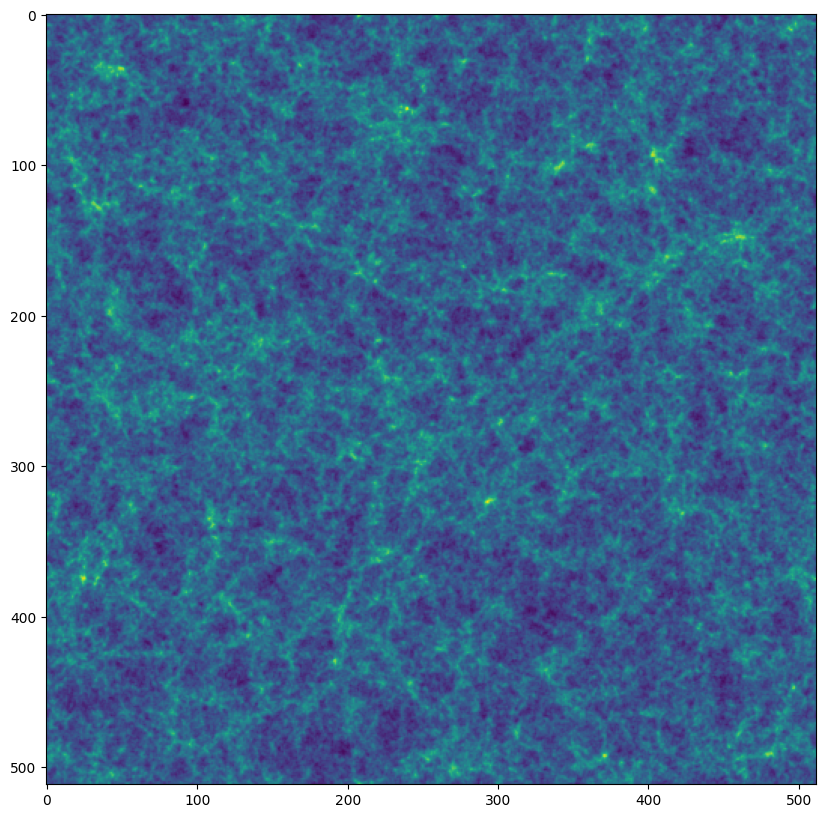

In [9]:
figure(figsize=[10,10])
imshow(res.sum(axis=-1))

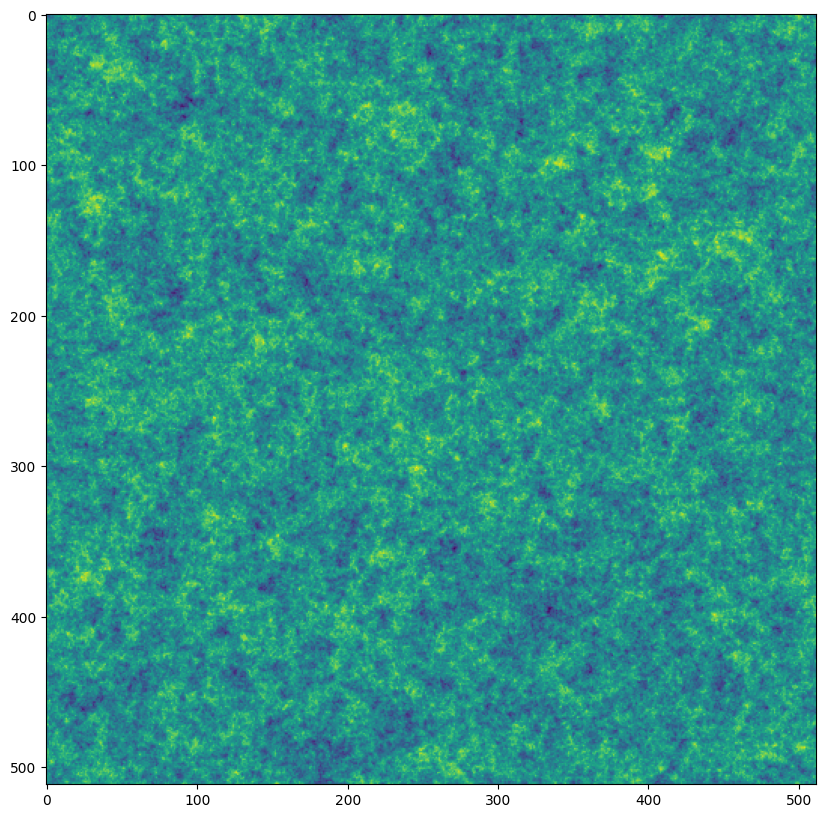

In [10]:
figure(figsize=[10,10])
imshow((0+initial_conditions).real.sum(axis=-1))

In [11]:
x_final_arr.shape

(512, 512, 512, 3)

In [12]:
jnp.save('../data_new/res_512.npy', res)

In [15]:
foo = jnp.load('../sim_cube.npy')

In [20]:
x_final.shape

(2, 256, 2, 256, 512, 3)

In [22]:
with Mesh(devices, ('nx', 'ny')):
    foo = pireshape(x_final)

In [23]:
foo.shape

(512, 512, 512, 3)